# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: ***321627960_313566747 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

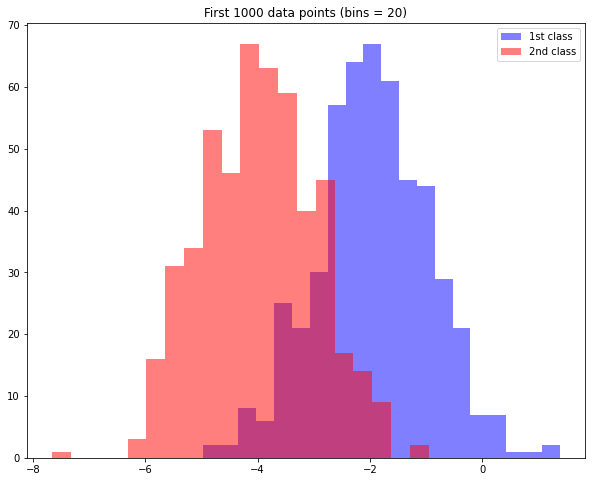

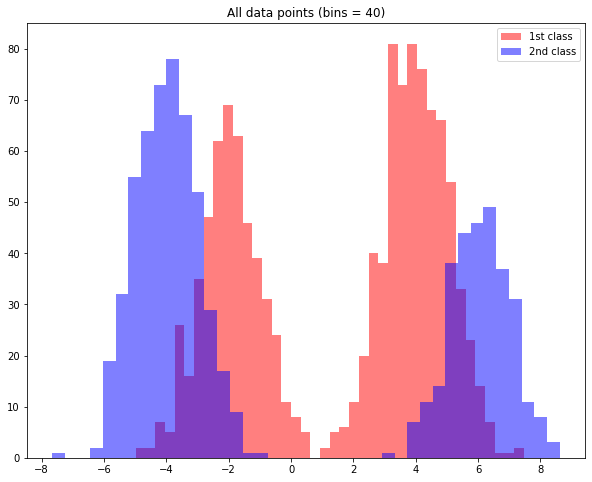

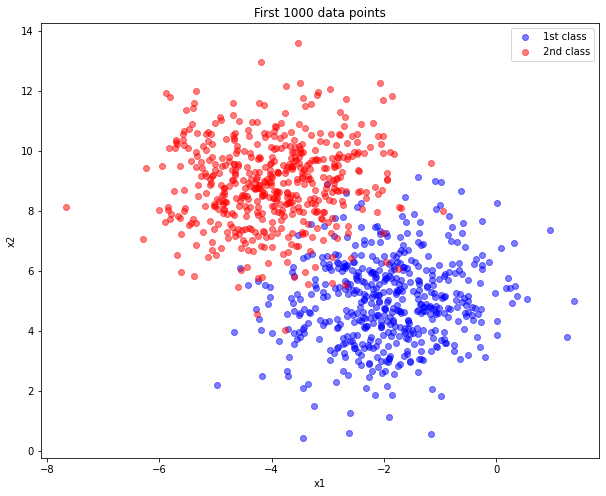

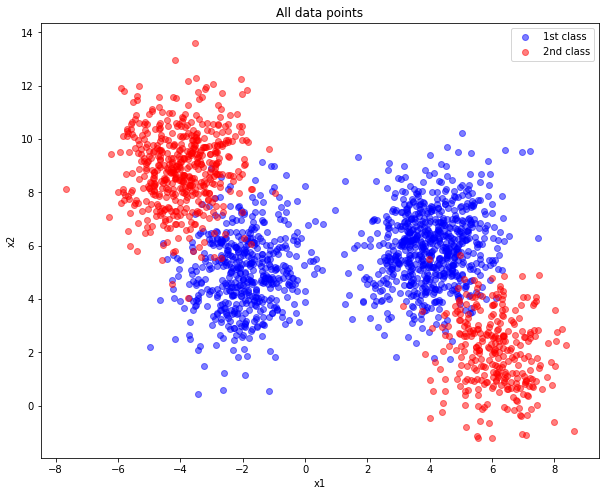

In [4]:
#### Your code here ####
x = X_training[:1000]
y = y_training[:1000]

### First feature only
#1 
plt.title("First 1000 data points (bins = 20)")
first_class = x[np.where(y==0)]
second_class = x[np.where(y==1)]
plt.hist(x = first_class[:,0], bins=20, alpha=0.5, color = 'blue', label = "1st class")
plt.hist(x = second_class[:,0] , bins=20, alpha=0.5, color = 'red', label = "2nd class")
plt.legend()
plt.show()

#2
plt.title("All data points (bins = 40)")
first_class = X_training[np.where(y_training==0)]
second_class = X_training[np.where(y_training==1)]
plt.hist(x = first_class[:,0], bins=40, alpha=0.5, color = 'red', label = "1st class")
plt.hist(x = second_class[:,0] , bins=40, alpha=0.5, color = 'blue', label ="2nd class")
plt.legend()
plt.show()

### Both features
#1
plt.title("First 1000 data points")
first_class = x[np.where(y==0)]
second_class = x[np.where(y==1)]
plt.scatter(first_class[:,0], first_class[:,1],color = 'blue', label = "1st class", alpha = 0.5)
plt.scatter(second_class[:,0], second_class[:,1],color = 'red', label = "2nd class", alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

#2
plt.title("All data points")
first_class = X_training[np.where(y_training==0)]
second_class = X_training[np.where(y_training==1)]
plt.scatter(first_class[:,0], first_class[:,1],color = 'blue', label = "1st class", alpha = 0.5)
plt.scatter(second_class[:,0], second_class[:,1],color = 'red', label = "2nd class", alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.theta = []
        self.costs_history = []
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # Using random seed
        np.random.seed(self.random_state)
        # Bias trick
        X = np.column_stack((np.ones(len(X)), X))
        # Initialize random theta
        self.theta = np.random.random(size=X.shape[1])
        
        XT = X.transpose()
        costs_history = []
        
        # Gradient descent
        for i in range (self.n_iter):
            h_theta = self.compute_htheta(X)
            error = h_theta - y
            sum_val = np.dot(XT, error)
            self.theta -= self.eta * sum_val
            costs_history.append(self.compute_cost(X, y))
            
            if i > 0 and np.abs(costs_history[i-1] - costs_history[i]) < self.eps:
                break
        self.costs_history = costs_history     
    
    def compute_cost(self, X, y):        
        h_theta = self.compute_htheta(X)
        ans = y * np.log(h_theta + 1.8e-320) + (1-y) * np.log(1-h_theta + 1.8e-320)
        return - np.sum(ans) / len(X)
    
    def compute_htheta(self, X):
        return 1.0 / (1 + np.exp(-np.dot(X, self.theta)))
    
    def predict(self, X):
        """Return the predicted class label"""
        x = np.column_stack((np.ones(len(X)), X))
        return np.around(self.compute_htheta(x))
        


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [6]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
num_folds = 5

# Shuffle the training set dataframe
shuffled_df = training_set.sample(frac=1)

# Extract X and y
X, y = shuffled_df[['x1', 'x2']].values, shuffled_df['y'].values

# Split data to 'num_folds' folds
X_folds = np.array_split(X, num_folds)
y_folds = np.array_split(y, num_folds)
max_accuracy = 0

for eta in etas:
    for eps in epss:
        accuracy_sum = 0
        for i in range(num_folds):
            # Split to 'num_folds'-1 training folds and 1 validation fold
            X_training_folds = np.concatenate(X_folds[:i] + X_folds[i+1:])
            y_training_folds = np.concatenate(y_folds[:i] + y_folds[i+1:])
            validation_fold = [X_folds[i], y_folds[i]]
        
            # Fit logistic regression model according to current eta and eps
            logistic_model = LogisticRegressionGD(eta=eta, eps=eps)
            logistic_model.fit(X_training_folds, y_training_folds)
            
            # Predict using the validation fold
            prediction = logistic_model.predict(validation_fold[0])
            
            # Calculate current round accuracy
            accuracy_sum += 1 - (np.sum(np.abs(prediction - validation_fold[1])) / len(validation_fold[1]))
            
        # Update max accuracy after 'num_folds' rounds of given eps and eta
        if (accuracy_sum / num_folds > max_accuracy):
            max_accuracy = accuracy_sum / num_folds
            best_eta = eta
            best_eps = eps


In [7]:
print("best eps: ", best_eps)
print("best eta: ", best_eta)

best eps:  1e-06
best eta:  5e-05


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    res = 1 / (sigma * np.sqrt(2 * np.pi))
    res *= np.exp(- 0.5 * (((data - mu) / sigma) ** 2))
    
    return res

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01 , random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.weights = []
        self.mus = []
        self.sigmas = []
        self.resp = []
        self.probs = []

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        data_splits = np.array_split(data, self.k)
        self.weights = np.ones(self.k) * (1 / self.k)
        for i in range(self.k):
            self.mus.append(np.mean(data_splits[i]))
            self.sigmas.append(np.std(data_splits[i]))
            
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        probs = np.empty([self.k, len(data)])
        
        for i in range(len(probs)):
            probs[i] = self.weights[i] * norm_pdf(data, self.mus[i], self.sigmas[i])
        self.probs = probs
        self.resp = probs / (np.sum(probs, axis=0))

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.weights = np.sum(self.resp, axis=1) / len(data)
                
        for i in range (self.k):
            # update mean and standard deviation
            self.mus[i] = np.dot(self.resp[i], data) / np.sum(self.resp[i])
            self.sigmas[i] = np.sqrt(np.dot(self.resp[i], (data - self.mus[i]) ** 2) / np.sum(self.resp[i]))

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prev_cost = 0
        
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            cost = self.compute_cost()
            if i > 0 and (np.abs(prev_cost - cost) < self.eps):
                break
            prev_cost = cost

    def get_dist_params(self):
        return (self.weights, self.mus, self.sigmas)
    
    def compute_cost(self):
        return np.sum(-np.log(np.sum(self.probs, axis=0)))
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1,random_state=1):
        self.k = k
        self.random_state = random_state
        self.priors = []
        self.class0_params = []
        self.class1_params = []
    

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        for i in range (X.shape[1]):
            em0 = EM(k = self.k, random_state = self.random_state)
            em0.fit(X[y == 0][:,i])
            self.class0_params.append(em0.get_dist_params())
            
            em1 = EM(k = self.k, random_state = self.random_state)
            em1.fit(X[y == 1][:,i])
            self.class1_params.append(em1.get_dist_params())
            
        self.priors = [len(X[y == 0]) / len(X), len(X[y == 1]) / len(X)]
        
    def get_instance_likelihood(self, x, params):
        """
        Returns the likelihhod porbability of the instance under the class according to the dataset distribution.
        """
        
        probs = []
        for i in range(len(params)):
            prob = 0
            for j in range(self.k):
                prob += params[i][0][j] * norm_pdf(x[:,i], params[i][1][j], params[i][2][j])
            probs.append(prob)
        
        return np.prod(probs, axis=0)
        
    
    def get_instance_posterior(self, x, params, class_num):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        return self.get_instance_likelihood(x, params) * self.priors[class_num]
    
    def predict(self, X):
        """Return the predicted class label"""
        prediction = np.ones(X.shape[0])
        prediction[np.where(self.get_instance_posterior(X, self.class0_params, 0) > self.get_instance_posterior(X, self.class1_params, 1))[0]] = 0

        return prediction


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

Logistic Regression GD

Train accuracy:  0.965
Test accuracy:  0.938

Naive Base with EM

Train accuracy:  0.966
Test accuracy:  0.942



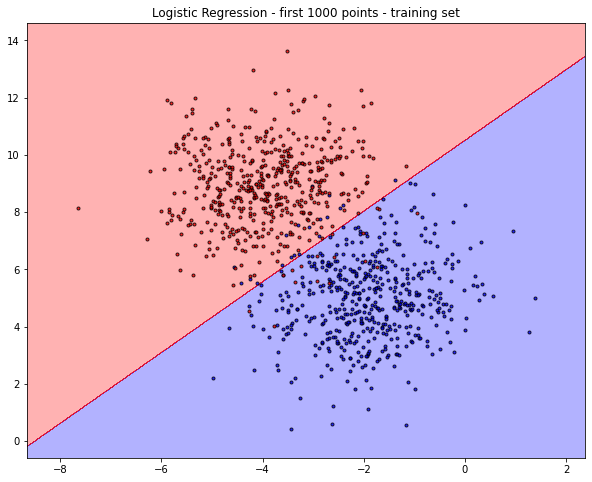

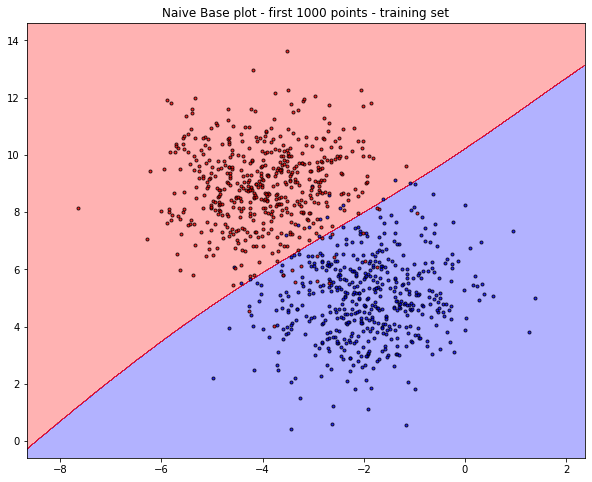

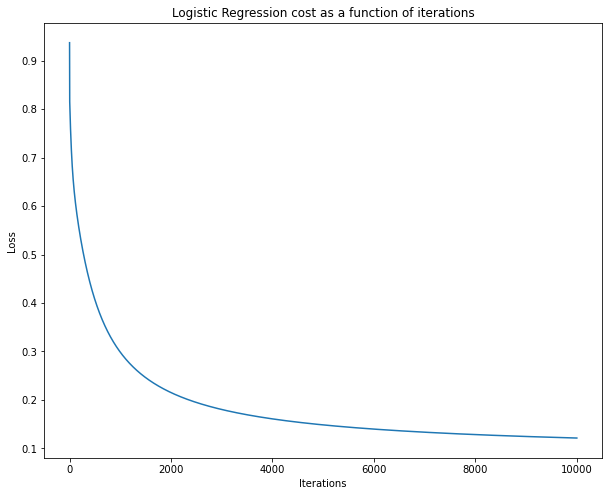

Logistic Regression GD

Train accuracy:  0.809
Test accuracy:  0.804

Naive Base

Train accuracy:  0.9215
Test accuracy:  0.902



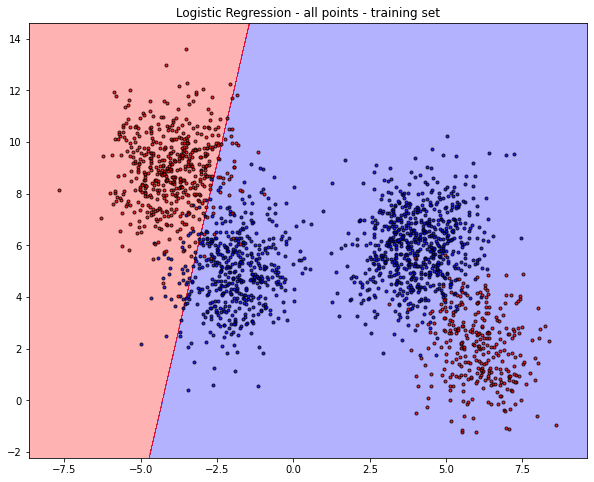

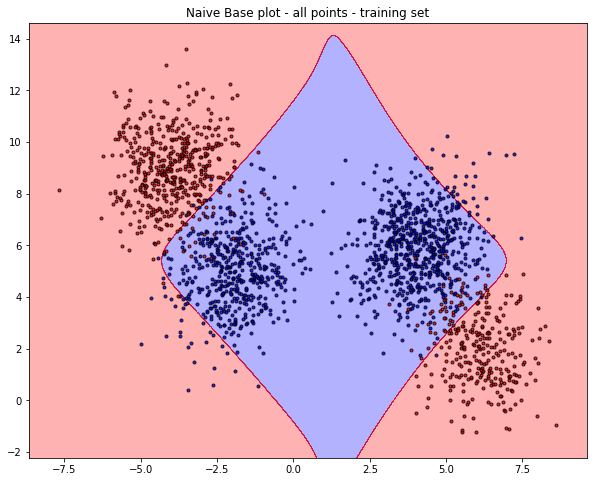

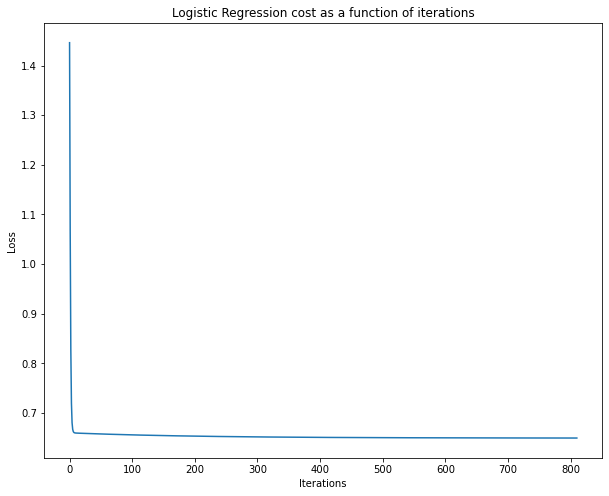

In [11]:
#### Your code here ####
### Training: top 1000, Test: top 500
def calc_accuracy(pred, y):
    acc = 0
    for i in range(y.shape[0]):
        acc += int(pred[i] == y[i])
    return acc / y.shape[0]



def f(X_training, y_training, X_test, y_test, alg):
    alg.fit(X_training, y_training)
    
    alg_pred_train = alg.predict(X_training)
    alg_acc_train = calc_accuracy(alg_pred_train, y_training)
    print("Train accuracy: ", alg_acc_train)
    
    alg_pred_test = alg.predict(X_test)
    alg_acc_test = calc_accuracy(alg_pred_test, y_test)
    print("Test accuracy: ", alg_acc_test)
    print()

############ First 1000 ###############
    
first1k_X_training = X_training[0:1000]
first1k_y_training = y_training[0:1000]
first_500_X_test = X_test[0:500]
first_500_y_test = y_test[0:500]
    
print("Logistic Regression GD\n")
lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
f(first1k_X_training, first1k_y_training,  first_500_X_test, first_500_y_test, lr)

print("Naive Base with EM\n")
nb = NaiveBayesGaussian(k=2)
f(first1k_X_training, first1k_y_training,  first_500_X_test, first_500_y_test, nb)

plt.figure()
plt.title("Logistic Regression - first 1000 points - training set")
plot_decision_regions(first1k_X_training, first1k_y_training, lr)
plt.show()

plt.figure()
plt.title("Naive Base plot - first 1000 points - training set");
plot_decision_regions(first1k_X_training, first1k_y_training, nb)
plt.show()

plt.figure()
plt.title("Logistic Regression cost as a function of iterations")
plt.plot(list(range(len(lr.costs_history))), lr.costs_history)
plt.xlabel("Iterations")
plt.ylabel('Loss')
plt.show()



################## All ######################

print("Logistic Regression GD\n")
lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
f(X_training, y_training,  X_test, y_test, lr)

print("Naive Base\n")
nb = NaiveBayesGaussian(k=4)
f(X_training, y_training,  X_test, y_test, nb)

plt.figure()
plt.title("Logistic Regression - all points - training set")
plot_decision_regions(X_training, y_training, lr)
plt.show()

plt.figure()
plt.title("Naive Base plot - all points - training set");
plot_decision_regions(X_training, y_training, nb)
plt.show()

plt.figure()
plt.title("Logistic Regression cost as a function of iterations")
plt.plot(list(range(len(lr.costs_history))), lr.costs_history)
plt.xlabel("Iterations")
plt.ylabel('Loss')
plt.show()

## Graph analysis - first 1000 points


1. Logistic Regression - first 1000 points - training set  
    - Note that for this model we produce a relatively accurate cut using the first 1000 points and dividers in the center.
2. Naive Base plot - first 1000 points - training set
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset. 
3. Logistic Regression cost as a function of iterations.  .  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.
    

## Graph analysis - Full Data


1. Logistic Regression - all points - training set 
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  
2. Naive Base plot - all points - training set
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset. 
3. Logistic Regression cost as a function of iterations  .  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.
    

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


In [12]:
#  Dataset that we think Naive Bayes will work better than Logisitc Regression.
x0 = np.random.normal(0,1,2000)
x1 = np.random.normal(0,1,2000)
y0 = ((pow(x0, 2) + pow(x1,2)) < 1).astype(int)
xd1 = np.column_stack((x0, x1))

The first dataset consists of 2000 data points, distributed normally and independently around 0. Then we created a circle with r=1 and assigned class 1 to all data points within this circle. Datapoints located out of this circle received class 0. 
Logistic regression performs poorly on this dataset because it's not linearly separable in this.
However. NB with EM will perform well on this dataset because this dataset is distributed independently and normally. 

In [13]:
# Dataset that you think Logistic Regression will work better than Naive Bayes using EM.
x0c0 = np.random.normal(1, 2, 1000)
x1c0 = x0c0 * 3 + np.random.normal(0, 1, 1000)
x0c1 = np.random.normal(1, 2, 1000)
x1c1 = x0c1 * 3 + np.random.normal(0, 1, 1000) + 10
mat1 = np.column_stack((x0c0, x1c0))
mat2 = np.column_stack((x0c1, x1c1))
xd2 = np.vstack((mat1, mat2))
yd2 = np.hstack((np.zeros(1000).astype(int), np.ones(1000).astype(int)))

The second dataset we are created is linear dependent. We have also created a dataset that is linearly separable so the LG algorithm performs well on it. NB performs poorly on this dataset due to the dependence of the features.

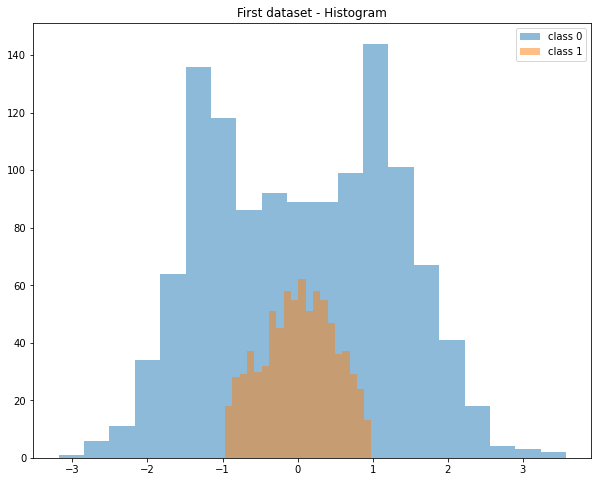

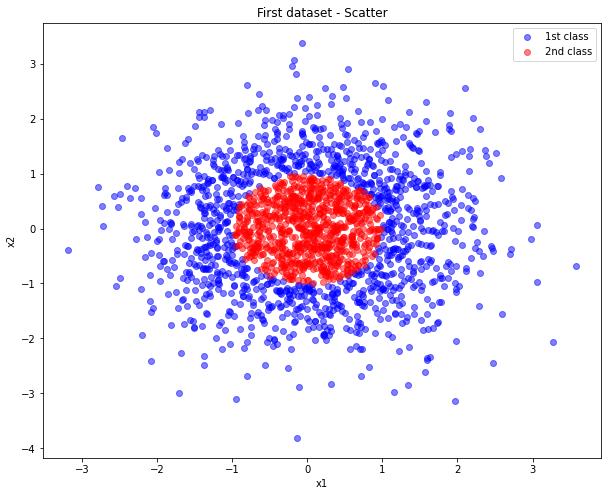

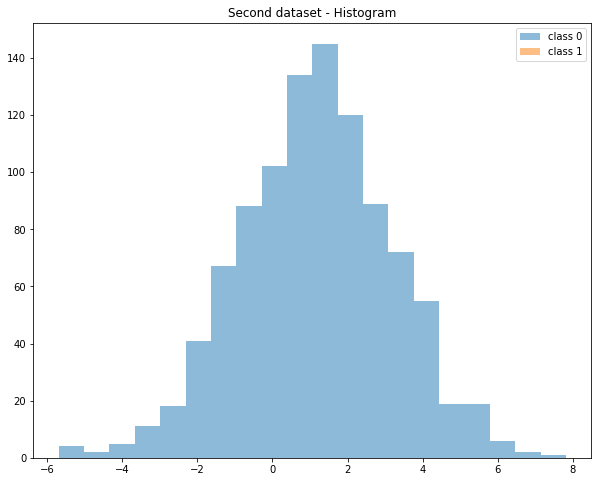

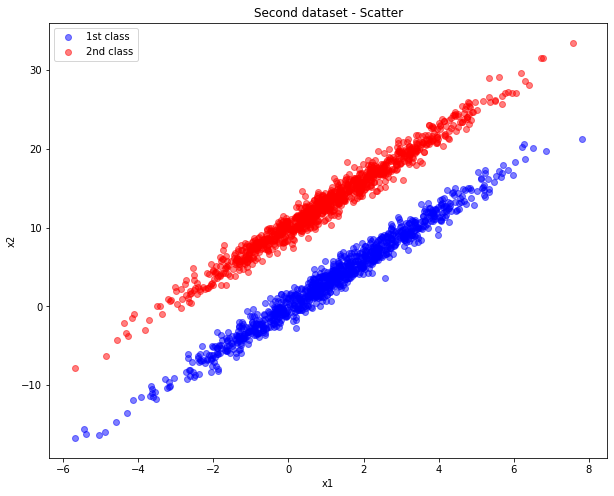

logistic reg on first data


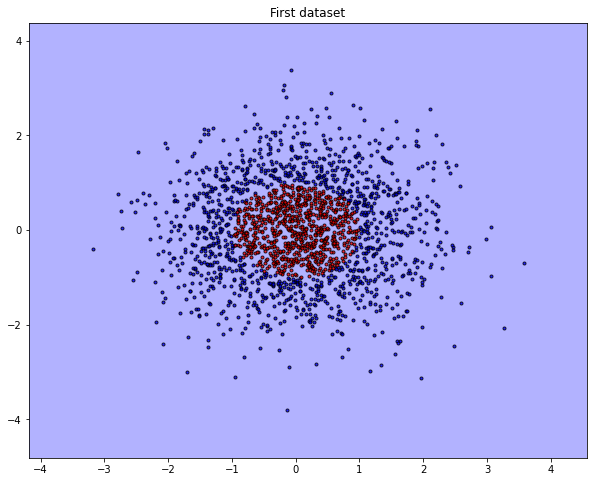

NB on first data


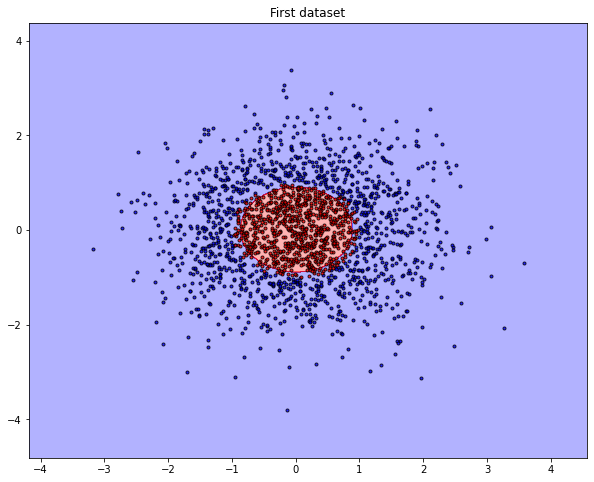

logistic reg on the second data


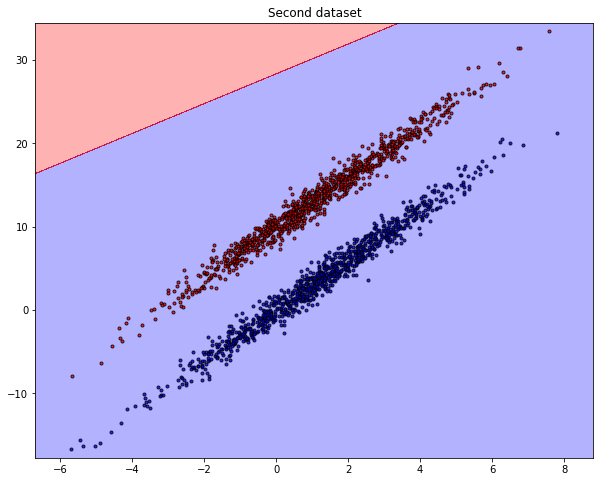

NB on the second data


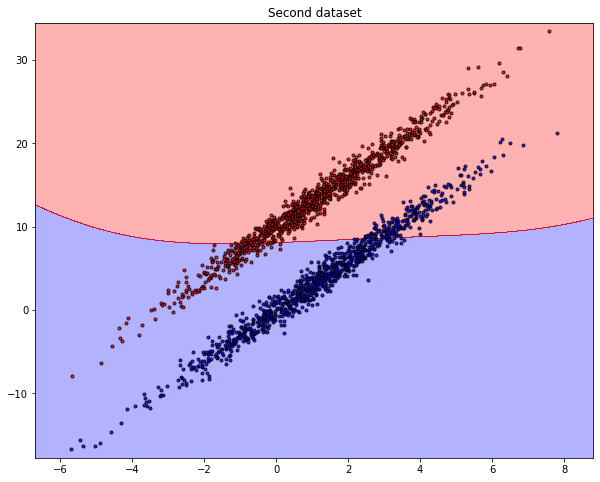

In [14]:
# First dataset - Histogram
plt.title("First dataset - Histogram")
plt.hist([xd1[i][0] for i in range(2000) if y0[i] == 0], bins=20, alpha=0.5, label="class 0")
plt.hist([xd1[i][0] for i in range(2000) if y0[i] == 1], bins=20, alpha=0.5, label="class 1")
plt.legend()
plt.show()

# First dataset - Scatter 
plt.title("First dataset - Scatter")
first_1_class = xd1[np.where(y0==0)]
second_1_class = xd1[np.where(y0==1)]
plt.scatter(first_1_class[:,0], first_1_class[:,1],color = 'blue', label = "1st class", alpha = 0.5)
plt.scatter(second_1_class[:,0], second_1_class[:,1],color = 'red', label = "2nd class", alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

# Second dataset - Histogram
plt.title("Second dataset - Histogram")
plt.hist([xd2[i][0] for i in range(1000) if yd2[i] == 0], bins=20, alpha=0.5, label="class 0")
plt.hist([xd2[i][0] for i in range(1000) if yd2[i] == 1], bins=20, alpha=0.5, label="class 1")
plt.legend()
plt.show()

# Second dataset - Scatter 
plt.title("Second dataset - Scatter")
first_2_class = xd2[np.where(yd2 == 0)]
second_2_class = xd2[np.where(yd2 == 1)]
plt.scatter(first_2_class[:,0], first_2_class[:,1],color = 'blue', label = "1st class", alpha = 0.5)
plt.scatter(second_2_class[:,0], second_2_class[:,1],color = 'red', label = "2nd class", alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

# Logistic Reg - first dataset
print("logistic reg on first data")
logistic_first = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_first.fit(xd1, y0)

plt.figure()
plt.title("First dataset");
plot_decision_regions(xd1, y0, logistic_first)
plt.show()

# Naive - first dataset
print("NB on first data")
naive = NaiveBayesGaussian(k=4, random_state=1)
naive.fit(xd1, y0)

plt.figure()
plt.title("First dataset");
plot_decision_regions(xd1, y0, naive)
plt.show()

# Logistic Reg - second dataset
print("logistic reg on the second data")
logistic_second = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_second.fit(xd1, y0)

plt.figure()
plt.title("Second dataset");
plot_decision_regions(xd2, yd2, logistic_second)
plt.show()

# Naive - first dataset
print("NB on the second data")
naive_second = NaiveBayesGaussian(k=4, random_state=1)
naive_second.fit(xd2, yd2)

plt.figure()
plt.title("Second dataset");
plot_decision_regions(xd2, yd2, naive_second)
plt.show()